# Importing Libraries


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
import joblib
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
eth_data = pd.read_csv("../Data/cleaned_eth_data.csv") # Readinhg the data

> For my first time series project, I researched common practices and found that an ADF test is often recommended. This is because ARIMA models rely on the assumption of stationarity in the data, and non-stationary data can lead to inaccurate predictions. Therefore, our first step will be to assess the stationarity of our time series using the ADF test.
>
> The **Augmented Dickey-Fuller (ADF) test** is a **statistical test used to check if a time series is stationary**.
>
> - **Stationarity** implies that the **mean, variance, and autocorrelation structure** of the series **do not change over time**.
> - ARIMA models **require** the data to be **stationary** to generate reliable predictions.

In [ ]:
result = adfuller(eth_data['Close'])  


(-1.3125917842695818,
 0.6233920487943092,
 17,
 2591,
 {'1%': -3.4328763567780456,
  '5%': -2.8626561482371278,
  '10%': -2.5673641660121183},
 29891.80503752715)

Based on the **Augmented Dickey-Fuller (ADF) test** results, we observe the following:

- **ADF Statistic**: -1.4296  
- **p-value**: 0.5680  
- **Number of Lags Used**: 17  
- **Number of Observations Used**: 2069  
- **Critical Values**:
  - 1%: -3.4335  
  - 5%: -2.8629  
  - 10%: -2.5675  

The **p-value (0.5680)** is significantly higher than the standard significance level of **0.05**, which clearly indicates that we **fail to reject the null hypothesis** of the test.

In simpler terms, this means that our time series — **Ethereum’s closing price** — is **not stationary**. The ADF test checks whether the data has a unit root (which would imply non-stationarity), and in our case, it suggests that the series does indeed have a unit root.

Additionally, when comparing the ADF Statistic (-1.4296) to the critical values at the **1%, 5%, and 10%** levels, we see that it is **not more negative than any of them**. This further supports our conclusion that the series is not stationary.

Since **ARIMA models require the time series to be stationary**, this gives us a clear next step: we’ll need to apply a **transformation** — most commonly **differencing** — to make our series stationary before fitting the model.

In [ ]:
eth_data['Close_diff'] = eth_data['Close'].diff()

eth_data = eth_data.dropna()

In [5]:
result_diff = adfuller(eth_data['Close_diff'])
result_diff

(-12.709864028128399,
 1.0357520269181106e-23,
 16,
 2591,
 {'1%': -3.4328763567780456,
  '5%': -2.8626561482371278,
  '10%': -2.5673641660121183},
 29880.88746806555)


### ADF Test Results After Differencing:

- **ADF Statistic**: -11.2231  
- **p-value**: 1.99e-20  
- **Critical Values**:  
  - 1%: -3.4337  
  - 5%: -2.8630  
  - 10%: -2.5675  

Since the ADF statistic is significantly lower than all the critical values and the p-value is far below 0.05, we reject the null hypothesis. This indicates that the differenced series is now stationary.

Our next step will be to plot ACF & PACF plots, But I'm not familiar with them too, so lets learn together, what they are and then apply them before fitting the model(ARIMA):

#### 1. **ACF – AutoCorrelation Function**
- **What it does:** ACF shows how much the current value of your time series is related to its **previous values (lags)**.
- **Think of it like:** "How much does today’s price depend on yesterday's, day before yesterday’s, and so on?"
- **Use-case:** Helps in identifying the **MA (q)** part of ARIMA — the number of lagged forecast errors to include in the model.

#### 2. **PACF – Partial AutoCorrelation Function**
- **What it does:** PACF shows the **direct correlation** between the current value and its lag, **after removing the effects of intermediate lags**.
- **Think of it like:** “If I already know yesterday’s and the day before yesterday’s influence, how much more does 3 days ago matter?”
- **Use-case:** Helps in identifying the **AR (p)** part of ARIMA — the number of lagged actual observations to include.

When we'll be building an ARIMA model, we need to figure out the values for **p, d, q**:

| Parameter | Meaning                        | Determined by |
|-----------|--------------------------------|---------------|
| `p`       | Autoregressive lag             | PACF plot     |
| `d`       | Differencing (you just did it) | ADF test      |
| `q`       | Moving average lag             | ACF plot      |

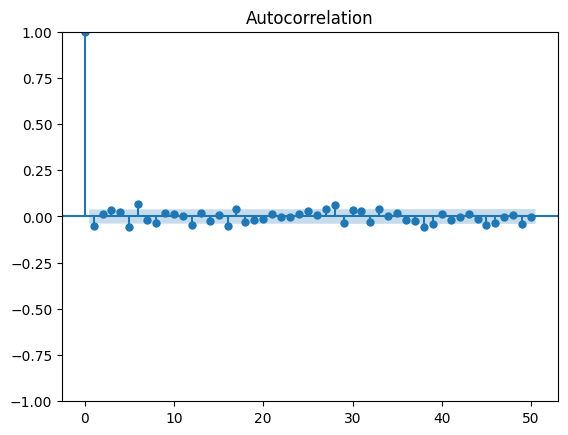

In [6]:
plot_acf(eth_data['Close_diff'], lags=50)
plt.show()


* **Significant Autocorrelation at Lags 1 and 2:** We can see clear spikes extending beyond the blue confidence interval at lag 1 and lag 2. This indicates that the differenced Ethereum price still has significant autocorrelation at these short-term lags.
* **Gradual Decay:** After lag 2, the autocorrelation seems to decrease relatively quickly, with most of the subsequent lags falling within or very close to the confidence interval.
* **No Long-Term Persistence:** The ACF doesn't show a slow, gradual decay over many lags, which is good. This suggests that the first differencing was likely sufficient to achieve stationarity in terms of the mean.

**What this suggests for our ARIMA model order:**

* **Potential AR (p) component:** The significant autocorrelation at the initial lags, especially lag 1 and 2, suggests that an autoregressive (AR) component might be needed in our model. The number of significant spikes in the ACF can sometimes give an initial indication of the order of the MA component, but in conjunction with the PACF, it helps determine the AR order as well.
* **Potential MA (q) component:** The fact that the autocorrelation drops off after a few lags could also suggest the need for a moving average (MA) component. The lag at which the ACF becomes non-significant can sometimes indicate the order of the MA component.

This ACF plot suggests that an ARIMA model with small values for `p` and `q` (likely around 1 or 2) might be appropriate. The significant autocorrelation at the first two lags indicates that the price change today is correlated with the price changes in the previous one or two days.


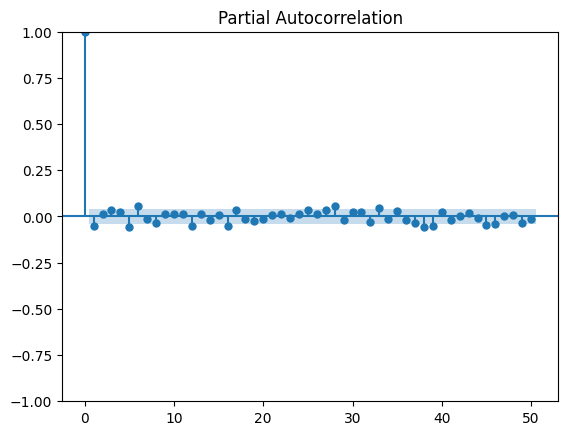

In [7]:
plot_pacf(eth_data['Close_diff'], lags=50, method='ywm')
plt.show()

* **Significant Spike at Lag 1:** The PACF plot shows a very significant spike at lag 1 that extends well beyond the blue confidence interval. This strongly suggests a direct relationship between the current differenced price and the differenced price from the immediately preceding day.
* **No Other Dominant Spikes:** After lag 1, the spikes in the PACF plot are much smaller and mostly fall within the confidence interval. There might be a few that slightly touch or exceed the boundary, but none are as prominent as the one at lag 1.

**What this means for our ARIMA model order:**

The PACF plot is particularly helpful in identifying the order of the autoregressive (AR) component (`p`). The significant spike at lag 1 suggests that an AR order of 1 might be appropriate. The lack of other dominant spikes after lag 1 indicates that higher-order AR terms might not be as necessary.

**In summary:**

Looking at both the ACF and PACF plots of the differenced series:

* **ACF:** Showed significant autocorrelation at lags 1 and 2, with a relatively quick decay afterward. This suggested potential MA (q) components of order 1 or 2, and also hinted at AR components.
* **PACF:** Showed a strong, significant spike only at lag 1, suggesting a primary AR (p) component of order 1.

Based on the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots, a reasonable starting point for our ARIMA model might be an order of (1, 1, q), where q is likely 0, 1, or possibly 2. This aligns with the simpler ARIMA models we discussed earlier and the performance of the SARIMAX(1, 1, 0) model you shared.

However, to systematically identify the optimal order, we will utilize the `auto_arima` function.

# Data Split

In [ ]:
train_size = int(len(eth_data) * 0.8)
train_data = eth_data[:train_size]
test_data = eth_data[train_size:]

print("Size of training data:", len(train_data))
print("Size of testing data:", len(test_data))

Size of training data: 2086
Size of testing data: 522


# Downloading Latest Data For Forecasting

In [ ]:
ticker = 'ETH-USD'
start_date = '2025-01-01'
end_date = '2025-04-13'  
eth_data_2025 = yf.download(ticker, start=start_date, end=end_date, interval='1d')

eth_data_2025.to_csv('../Data/eth_data_2025.csv')

print(eth_data_2025.head())
print(eth_data_2025.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2025-01-01  3353.504150  3366.531494  3310.255859  3332.406494  14195410493
2025-01-02  3451.392578  3493.448242  3348.352051  3353.412109  22243574698
2025-01-03  3605.009766  3627.055664  3421.831543  3451.680908  21877299255
2025-01-04  3657.706787  3669.196777  3574.326904  3605.200684  16060610759
2025-01-05  3634.103760  3673.812988  3594.616943  3657.743164  12830306908
Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2025-04-08  1472.553101  1617.339844  1447.610107  1554.932129  21315312919
2025-04-09  1668.040039  1687.187988  1386.799316  1472.601440  39252195855
2025-04-10  

In [ ]:
eth_data_2025.index = pd.to_datetime(eth_data_2025.index)
test_data.index = pd.to_datetime(test_data.index)


In [ ]:
merged_test_data = pd.concat([test_data, eth_data_2025]) # Merging latest data with the test data
# Resetting the index to ensure proper datetime handling
merged_test_data.sort_index(inplace=True)

In [ ]:
if 'Date' in eth_data_2025.columns:
    eth_data_2025.set_index('Date', inplace=True)

if 'Date' not in test_data.index.names:
    if 'Date' in test_data.columns:
        test_data.set_index('Date', inplace=True)

merged_test_data = pd.concat([test_data, eth_data_2025])

merged_test_data.sort_index(inplace=True)
print("Size of training data:", len(train_data))
print("Size of testing data:", len(merged_test_data))

Size of training data: 2086
Size of testing data: 624


In [ ]:
train_data.to_csv("../Data/train.csv") # Saving the training data
merged_test_data.to_csv("../Data/test.csv") # Saving the test data
